# PDFs and Normalization

In this tutorial, we discuss the treatment of histograms as probality density functions(PDFs).

.. contents:: :local:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import histlite as hl

%matplotlib inline

## Histogram as PDF

We begin by designing artificial "data" distributions with which to test various features.  First, a non-trivial 1D distribution:

In [2]:
props1d = dict(loc=np.r_[20, 33, 60], scale=np.r_[5, 8, 13], norm=np.r_[.2, .3, 0.5])

In [3]:
def pdf1d(x):
    pdf0 = props1d['norm'][0] * stats.norm.pdf(x, props1d['loc'][0], props1d['scale'][0])
    pdf1 = props1d['norm'][1] * stats.norm.pdf(x, props1d['loc'][1], props1d['scale'][1])
    pdf2 = props1d['norm'][2] * stats.norm.pdf(x, props1d['loc'][2], props1d['scale'][2])
    return pdf0 + pdf1 + pdf2

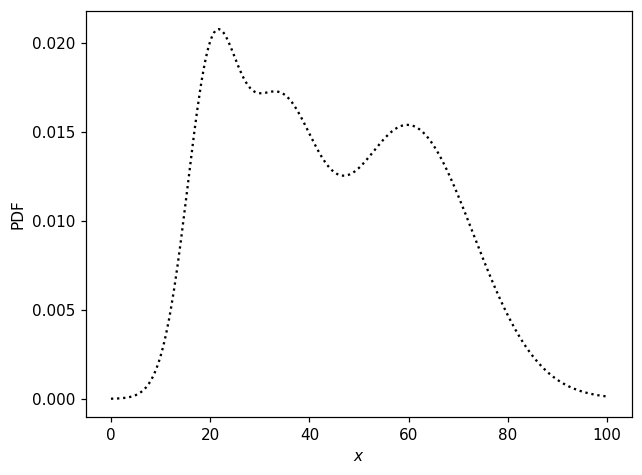

In [4]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF');

We can obtain random numbers distributed according to this distribution like so:

In [5]:
def random1d(N):
    loc = props1d['loc']
    scale = props1d['scale']
    norm = props1d['norm']
    which = np.random.choice(3, p=norm, size=N)
    return np.random.normal(loc[which], scale[which])

In [6]:
np.random.seed(1)
X = random1d(10000)

The histogram of these values looks like so:

In [7]:
h1d = hl.hist(X, bins=50, range=(0, 100))
h1d

Hist(50 bins in [0.0,100.0], with sum 9993.0, 1 empty bins, and 0 non-finite values)

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


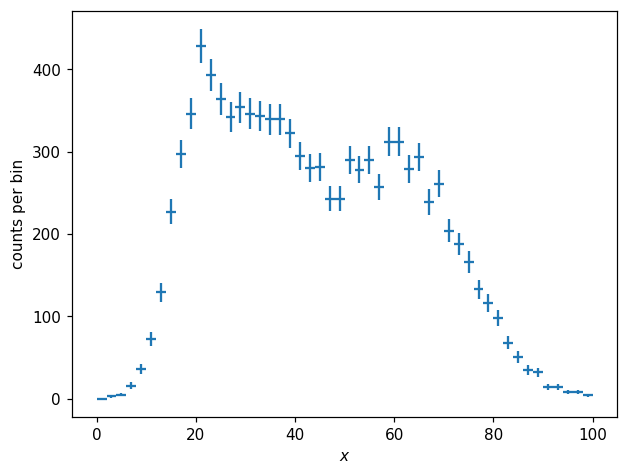

In [8]:
fig, ax = plt.subplots()
hl.plot1d(h1d, crosses=True)
ax.set_xlabel('$x$')
ax.set_ylabel('counts per bin');

We can obtain a normalized histogram like so:

In [9]:
p1d = h1d.normalize()

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


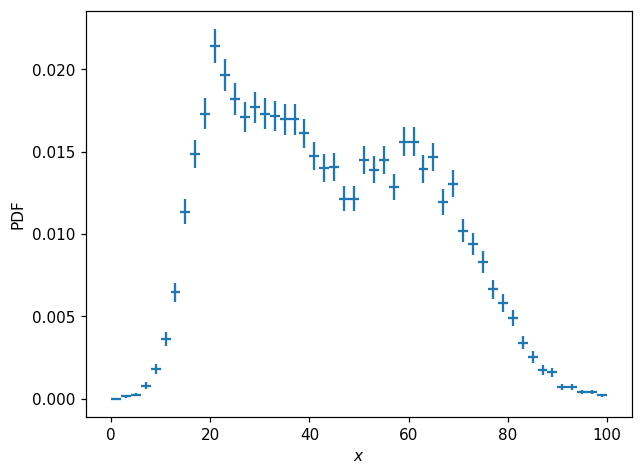

In [10]:
fig, ax = plt.subplots()
hl.plot1d(p1d, crosses=True)
ax.set_xlabel('$x$')
ax.set_ylabel('PDF');

The difference between `h1d` and `p1d` here is simply a scalar factor; `p1d` represents the PDF $p(x)$.  We can compare the integrals of each histogram:

In [11]:
print(h1d.integrate())
print(p1d.integrate())

Hist(with value 19986.0)
Hist(with value 1.0)


Notice that integrating `p1d` yields a value of 1.  Notice also that the result of the integral is still a `Hist` instance, similar to certain dimensionality-agnostic numpy operations which yield 0-dimensional `ndarray` instances.  This generality is useful because, as we will see below, integration and normalization can be performed along specified axes.

We can also compute the probability mass function(PMF) by normalizing such that the sum, rather than integral, will be unity:

In [12]:
pmf1d = h1d.normalize(integrate=False)
pmf1d

Hist(50 bins in [0.0,100.0], with sum 1.0, 1 empty bins, and 0 non-finite values)

So while the value for each bin in `p1d` represents the probability density across that bin, $p(x)$, the values of `pmf1d` represent the total probability within each bin, $\text{pmf}(i)=\int_{x_i}^{x_{i+1}}p(x)\,dx$.

We can see that the normalized histogram is a decent representation of the underlying distribution:

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


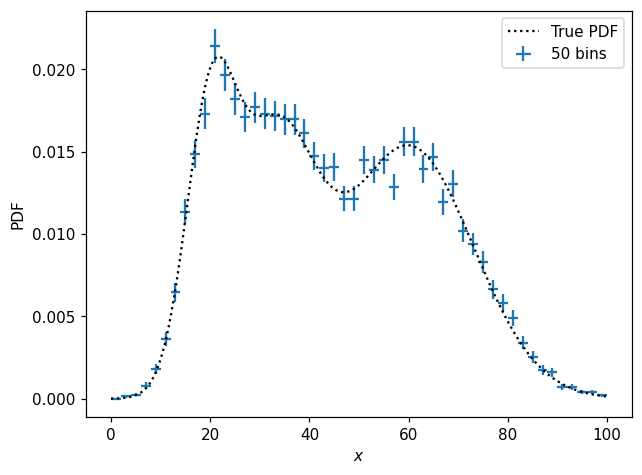

In [13]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:', label='True PDF')
hl.plot1d(p1d, crosses=True, label='50 bins')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF')
ax.legend();

## PDF Modeling

We might be interested in inferring a smooth PDF given a histogram of some real(in this case, "real") data.  One simple solution is to fit a spline:

In [14]:
s1d = p1d.spline_fit()

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


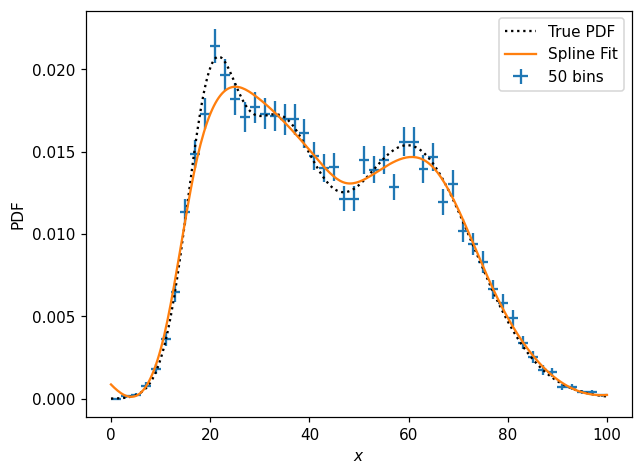

In [15]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:', label='True PDF')
hl.plot1d(p1d, crosses=True, label='50 bins')
ax.plot(x, s1d(x), label='Spline Fit')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF')
ax.legend();

What is `s1d`?

In [16]:
type(s1d)

histlite.SplineFit

histlite spline fits are thin wrappers around `scipy.interpolate` objects.  In this case, we have a `UnivariateSpline`:

In [17]:
s1d.spline

One nice feature of this wrapper is that it is readily interoperable with ordinary `Hist` objects:

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


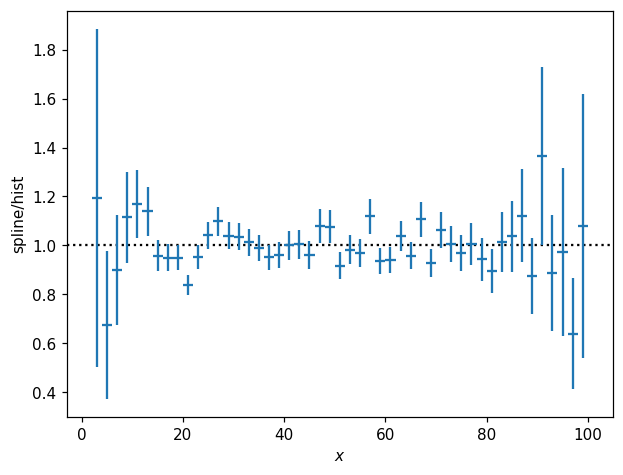

In [18]:
fig, ax = plt.subplots()
hl.plot1d(s1d.eval(bins=p1d.bins) / p1d, crosses=True)
ax.axhline(1, color='k', ls=':', zorder=-1)
ax.set_xlabel('$x$')
ax.set_ylabel('spline/hist');

It can sometimes be convenient to fit the spline in log-value space, which can be very handy e.g. when we know the underlying function is strictly positive.  Meanwhile, we also have access to the constructor kwargs for the internally-used `scipy.interpolate` object:

In [19]:
s1d_pos = p1d.spline_fit(log=True, s=30)

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


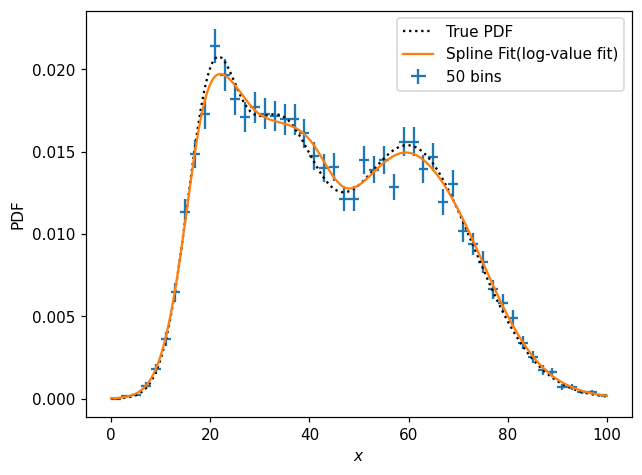

In [20]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:', label='True PDF')
hl.plot1d(p1d, crosses=True, label='50 bins')
ax.plot(x, s1d_pos(x), label='Spline Fit(log-value fit)')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF')
ax.legend();

We might, however, notice(or perhaps know *a priori*) that the function is in fact a combination of three Gaussians.  Then we can perform a fit to an analytic model:

In [21]:
def model_p1d(x, m0, m1, m2, s0, s1, s2, f0, f1):
    f2 = 1 - f0 - f1
    pdf0 = f0 * stats.norm.pdf(x, m0, s0)
    pdf1 = f1 * stats.norm.pdf(x, m1, s1)
    pdf2 = f2 * stats.norm.pdf(x, m2, s2)
    return pdf0 + pdf1 + pdf2

In [22]:
params1d, cov = p1d.curve_fit(model_p1d, p0=(20, 40, 60, 5, 5, 5, .3, .3))
params1d

array([19.70170103, 32.76340277, 60.96181126,  4.83091852,  9.26921554,
       12.88940782,  0.16090333,  0.36418666])

How do these compare with the true values?

In [23]:
print(params1d)
true_params1d = np.r_[props1d['loc'], props1d['scale'], props1d['norm'][:-1]]
print(true_params1d)
print(params1d / true_params1d)

[19.70170103 32.76340277 60.96181126  4.83091852  9.26921554 12.88940782
  0.16090333  0.36418666]
[20.  33.  60.   5.   8.  13.   0.2  0.3]
[0.98508505 0.99283039 1.01603019 0.9661837  1.15865194 0.99149291
 0.80451667 1.21395554]


And how does the model fit actually look?

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


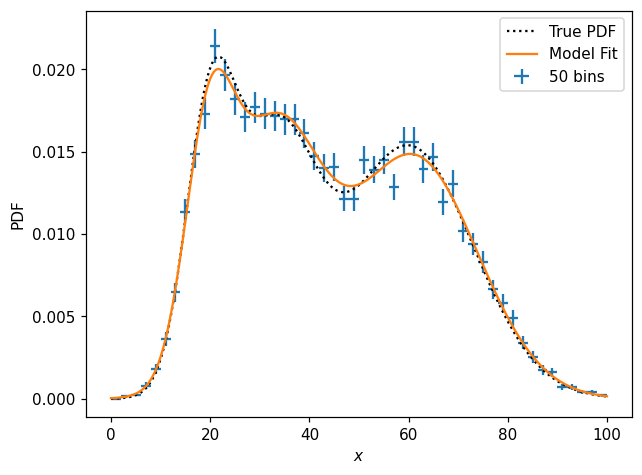

In [24]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:', label='True PDF')
hl.plot1d(p1d, crosses=True, label='50 bins')
ax.plot(x, model_p1d(x, *params1d), label='Model Fit')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF')
ax.legend();

Finally, note that we can often get a reasonable representation of a distribution using a sort of approximate KDE provided by histlite:

In [25]:
# kernel expressed as fraction of axis range
k1d = hl.kde(X, kernel=.02)
k1d

Hist(1000 bins in [2.820370949977928,106.97260109208092], with sum 9.601330654520044, 0 empty bins, and 0 non-finite values)

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


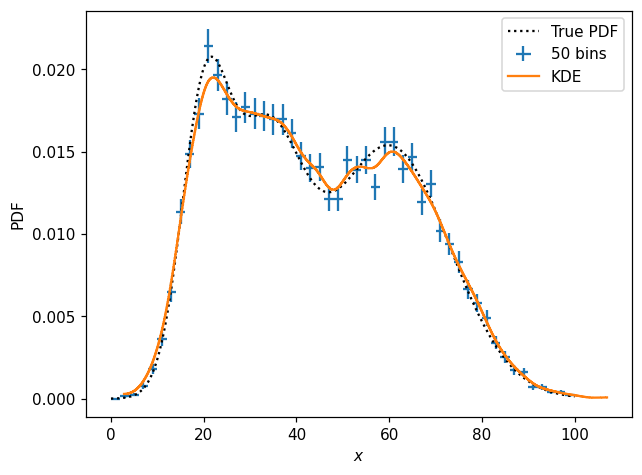

In [26]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 300)
ax.plot(x, pdf1d(x), 'k:', label='True PDF')
hl.plot1d(p1d, crosses=True, label='50 bins')
hl.plot1d(k1d, label='KDE')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF')
ax.legend();

The approximate KDE implemented by histlite is achieved by starting with a densely binned histogram and then using `scipy.ndimage` to apply a Gaussian smoothing with a kernel $\sigma$ expressed as a percent of the axis range — and then finally (by default) normalized to integrate to unity.

It is up to you, of course, to determine the best way to model your distributions.  Let's wrap up this section by comparing the various models we came up with — by the way, notice that `Hist` instances are callable, accepting one positional argument per dimension, returning the value of the corresponding bin(s):

/home/mike/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


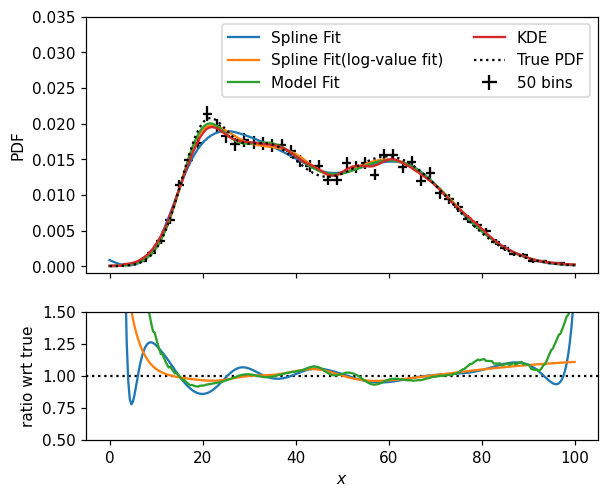

In [27]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(6,5), sharex=True, gridspec_kw=dict(height_ratios=[2,1]))
x = np.linspace(0, 100, 300)

# with multiple axes in play, we need to specify ax(so, not rax) here
hl.plot1d(ax, p1d, color='k', crosses=True, label='50 bins')
ax.plot(x, s1d(x), label='Spline Fit')
ax.plot(x, s1d_pos(x), label='Spline Fit(log-value fit)')
ax.plot(x, model_p1d(x, *params1d), label='Model Fit')
ax.plot(x, k1d(x), label='KDE')
ax.plot(x, pdf1d(x), 'k:', label='True PDF')

rax.plot(x, s1d(x) / pdf1d(x))
rax.plot(x, model_p1d(x, *params1d) / pdf1d(x))
rax.plot(x, k1d(x) / pdf1d(x))
rax.axhline(1, color='k', ls=':', zorder=-1)

ax.legend(ncol=2)
ax.set_ylim(-0.001, .035)
rax.set_ylim(.5, 1.5)
ax.set_ylabel('PDF')
rax.set_xlabel('$x$')
rax.set_ylabel(r'ratio wrt true');

## PDF Sampling

For many applications, it is useful to be able to randomly sample from a histogram.  You may specify a `seed` for the random number generator(this uses a local random state and does not affect the behavior of `np.random.*` functions).  The histogram need not, but may, already be normalized in some way:

In [28]:
N, seed = 10, 1
print(h1d.sample(N, seed=seed))
print(p1d.sample(N, seed=seed))
print(pmf1d.sample(N, seed=seed))

[array([36.83838903, 59.370439  ,  2.4089045 , 31.75623487, 20.05477519,
       19.34093502, 22.8346096 , 33.11737966, 34.28077388, 44.39620298])]
[array([36.83838903, 59.370439  ,  2.4089045 , 31.75623487, 20.05477519,
       19.34093502, 22.8346096 , 33.11737966, 34.28077388, 44.39620298])]
[array([36.83838903, 59.370439  ,  2.4089045 , 31.75623487, 20.05477519,
       19.34093502, 22.8346096 , 33.11737966, 34.28077388, 44.39620298])]


If you already have a `np.random.RandomState` instance, it can also be used:

In [29]:
random = np.random.RandomState(seed)
print(h1d.sample(N, random=random))

[array([36.83838903, 59.370439  ,  2.4089045 , 31.75623487, 20.05477519,
       19.34093502, 22.8346096 , 33.11737966, 34.28077388, 44.39620298])]


Notice that, similar to `Hist.bins`, the return here is a sequence; in the case of higher dimensionality histograms, the result is one array per dimension.

At present, there is no implementation for randomly sampling directly from a `SplineFit`.  However, sampling is of course possible after evaluating the spline on a grid:

In [30]:
print(s1d_pos.eval(bins=1000).sample(N, seed=seed))

[array([36.74191945, 58.16852195,  2.42044522, 29.98781174, 21.60273876,
       18.76704675, 23.64173048, 32.55586898, 35.51403869, 44.71981015])]


And of course sampling also works for the densely binned pseudo-KDE:

In [31]:
print(k1d.sample(N, seed=seed))

[array([36.81765802, 58.19657229,  3.1541218 , 30.09556091, 21.57062485,
       18.72134062, 23.59012797, 32.56194533, 35.53879283, 44.81435241])]


You may have noticed that the random samples are very similar too each other, even though the details of the distributions differ, as long as the same random state is used.  This is because, internally, [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) is used, with only a single `random.uniform(0, 1, N)` call driving the randomness.  In this case, all the CDFs are very similar.

Speaking of CDFs, these are straightforward to compute and plot as well:

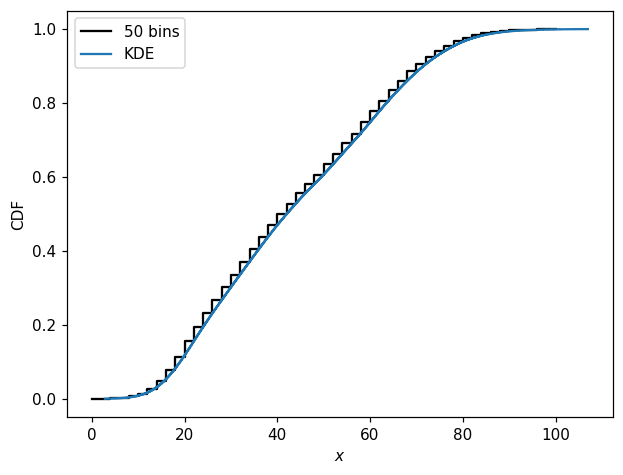

In [32]:
fig, ax = plt.subplots()
hl.plot1d(pmf1d.cumsum(), color='k', label='50 bins')
hl.plot1d(k1d.cumsum(normalize=True), label='KDE')
ax.set_xlabel(r'$x$')
ax.set_ylabel('CDF')
ax.legend();

In [33]:
from importlib import reload
reload(hl)

<module 'histlite' from '/home/mike/src/histlite/histlite/__init__.py'>

## 2D Histograms

histlite provides all of the above functionality for 2D histograms — and then some!  Let's walk through each feature, using an 2D elliptical Gaussian as our example:

In [34]:
np.random.seed(1)
N = 10000
X0 = np.random.normal(0, np.exp(1), N)
Y0 = np.random.normal(0, 1, N)
theta = np.radians(30)
X = X0 * np.cos(theta) - Y0 * np.sin(theta)
Y = X0 * np.sin(theta) + Y0 * np.cos(theta)

In [35]:
h2d = hl.hist((X, Y), bins=50, range=((-6,6), (-6,6)))
h2d

Hist(50 bins in [-6.0,6.0], 50 bins in [-6.0,6.0], with sum 9876.0, 1382 empty bins, and 0 non-finite values)

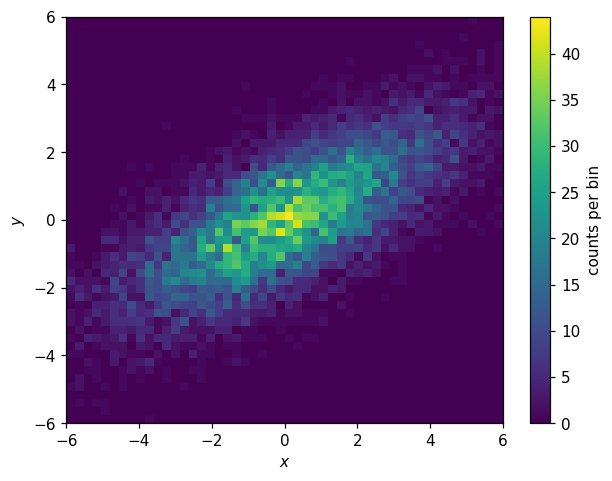

In [36]:
fig, ax = plt.subplots()
hl.plot2d(h2d, cbar=True, clabel='counts per bin')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

**Joint and Conditional PDFs**

We can compute the joint PDF $p(x,y)$:

In [37]:
p2d = h2d.normalize()

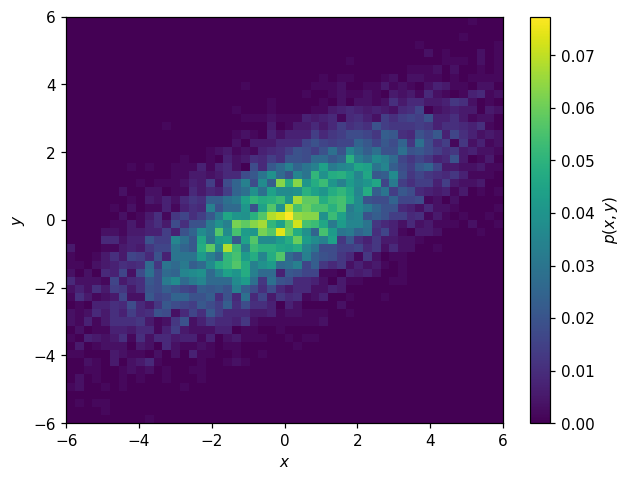

In [38]:
fig, ax = plt.subplots()
hl.plot2d(p2d, cbar=True, clabel='$p(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Or the joint PMF:

In [39]:
pmf2d = p2d.normalize(integrate=False)

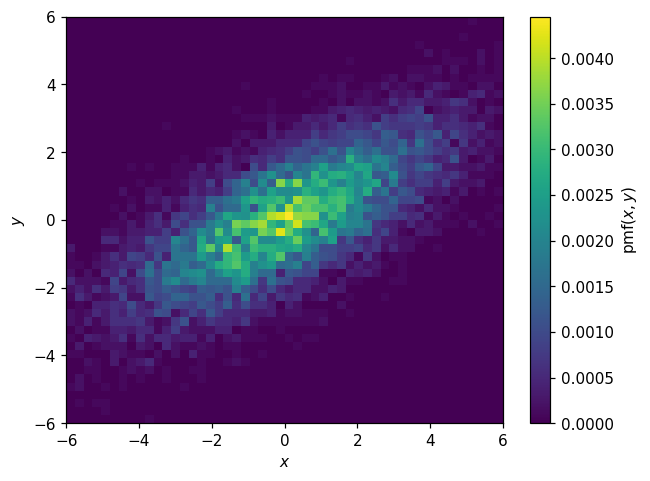

In [40]:
fig, ax = plt.subplots()
hl.plot2d(pmf2d, cbar=True, clabel='$\mathsf{pmf}(x,y)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

For multi-dimensional histograms, we can also work with conditional PDFs:

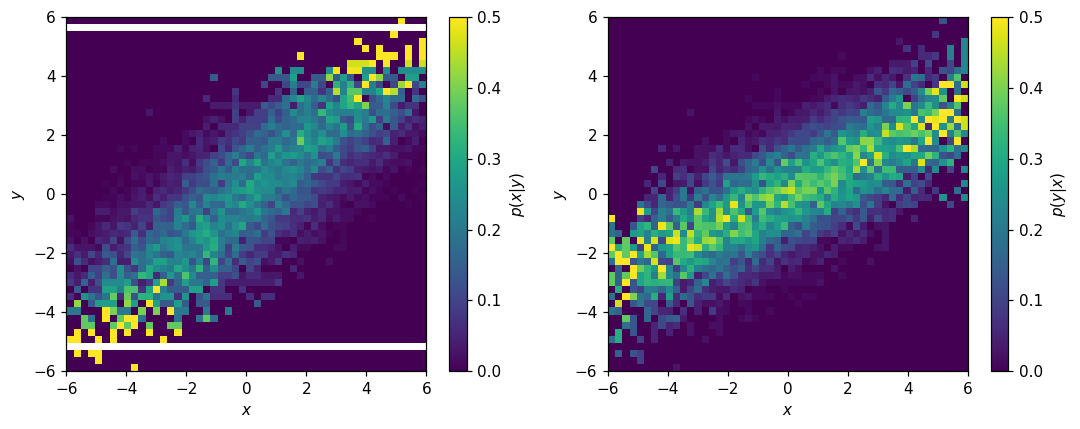

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
hl.plot2d(ax1, h2d.normalize(0), cbar=True, vmax=.5, clabel='$p(x|y)$')
hl.plot2d(ax2, h2d.normalize(1), cbar=True, vmax=.5, clabel='$p(y|x)$')
for ax in (ax1, ax2):
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
plt.tight_layout();

Depending on the application, the presence of empty bins in $p(x|y)$ may be a problem.  One way to address these is with the `to_finite()` method:

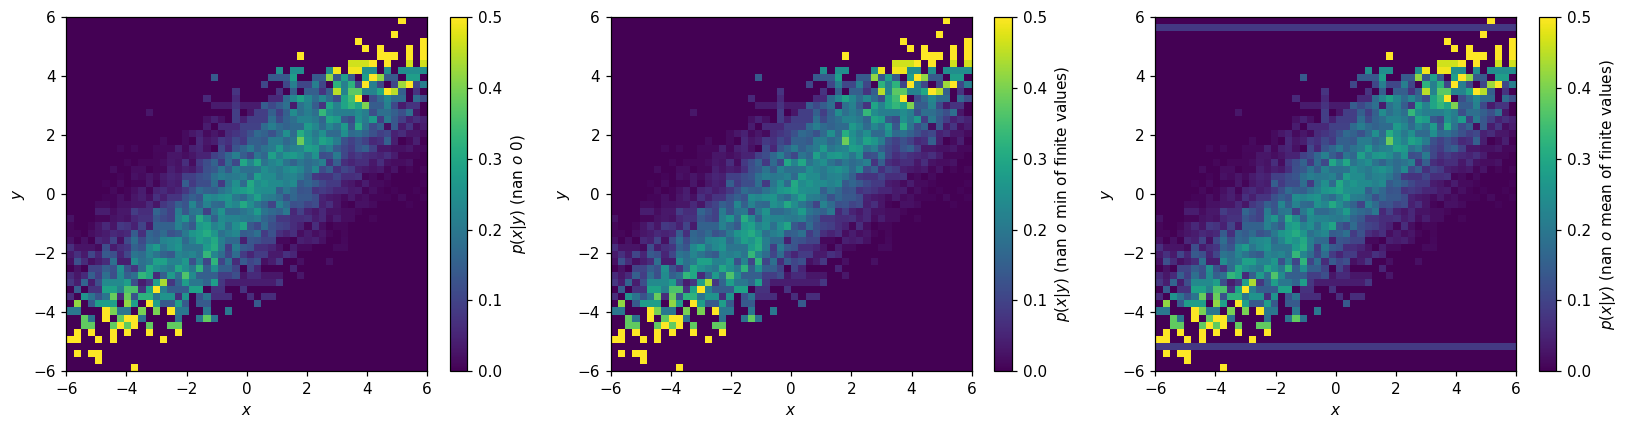

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
hl.plot2d(ax1, h2d.normalize(0).to_finite(), cbar=True, vmax=.5,
          clabel='$p(x|y)$ (nan $\to$ 0)')
hl.plot2d(ax2, h2d.normalize(0).to_finite(nan=np.min), cbar=True, vmax=.5,
          clabel='$p(x|y)$ (nan $\to$ min of finite values)')
hl.plot2d(ax3, h2d.normalize(0).to_finite(nan=np.mean), cbar=True, vmax=.5,
          clabel='$p(x|y)$ (nan $\to$ mean of finite values)')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
plt.tight_layout();

Alternatively, if you are sure you know what you're doing, you can modify the values directly:

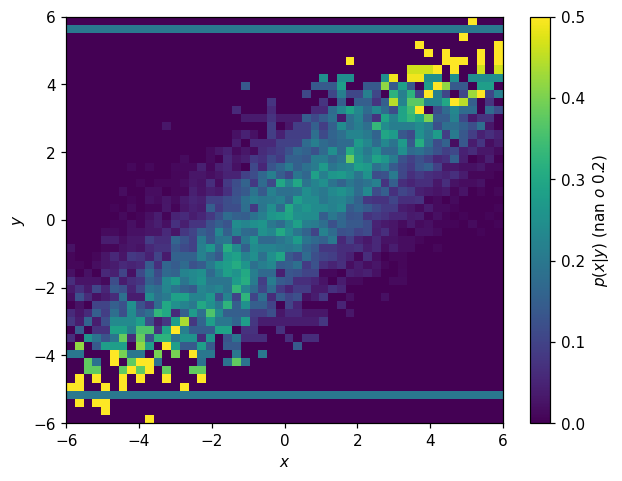

In [43]:
fig, ax = plt.subplots()
p2d_x_y = h2d.normalize(0)
p2d_x_y.values[~np.isfinite(p2d_x_y.values)] = 0.2
hl.plot2d(p2d_x_y, cbar=True, vmax=.5,
          clabel='$p(x|y)$ (nan $\to$ 0.2)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

**Modeling**

We have spline, curve fitting, and KDE here as well.  Here's a spline fit:

In [44]:
s2d = p2d.spline_fit(s=.03, kx=2, ky=2)

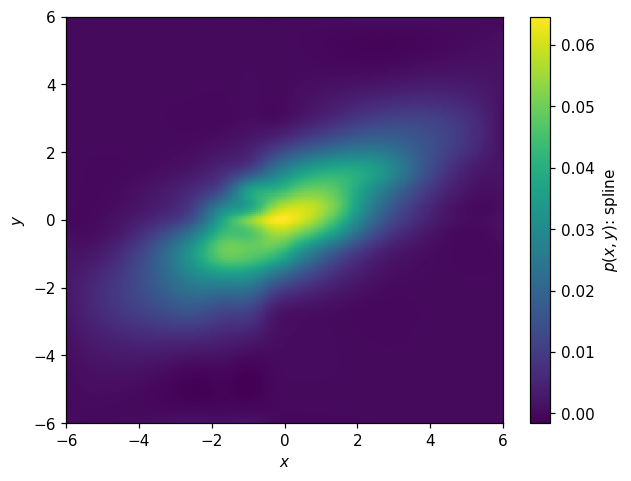

In [45]:
fig, ax = plt.subplots()
hl.plot2d(s2d.eval(bins=200), cbar=True, clabel='$p(x,y)$: spline')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

KDE:

In [46]:
k2d = hl.kde((X,Y), range=p2d.range, kernel=.03)

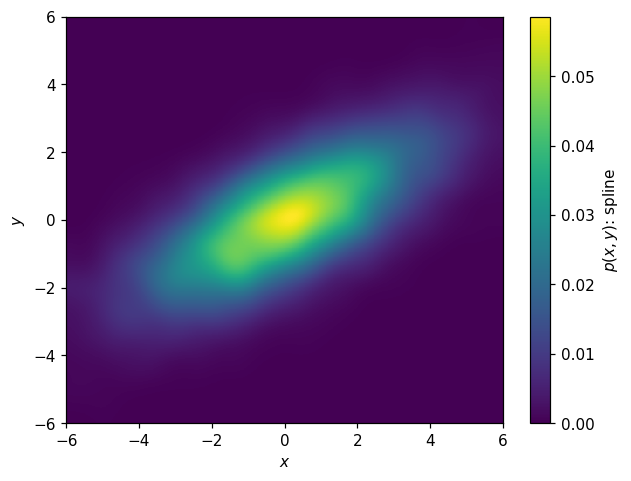

In [47]:
fig, ax = plt.subplots()
hl.plot2d(k2d, cbar=True, clabel='$p(x,y)$: spline')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Analytical model:

In [48]:
def model_p2d(XY, loc1, scale1, loc2, scale2, theta):
    X, Y = XY
    X0 = X * np.cos(theta) + Y * np.sin(theta)
    Y0 = -X * np.sin(theta) + Y * np.cos(theta)
    return stats.norm.pdf(X0, loc1, scale1) * stats.norm.pdf(Y0, loc2, scale2)

In [49]:
params2d, cov = p2d.curve_fit(model_p2d, p0=(0, 3, 0, 1, np.radians(10)))
params2d

array([0.09721215, 2.64869243, 0.01828913, 0.99518638, 0.5387843 ])

In [50]:
np.degrees(params2d[-1])

30.870066424450698

Now might be a good time to point out that we can also construct a histogram from a callable function.  Let's try it with this model, and then plot it:

In [51]:
h_model_p2d = hl.hist_from_eval(
    (lambda x, y: model_p2d((x,y), *params2d)),
    vectorize=False, bins=k2d.bins)

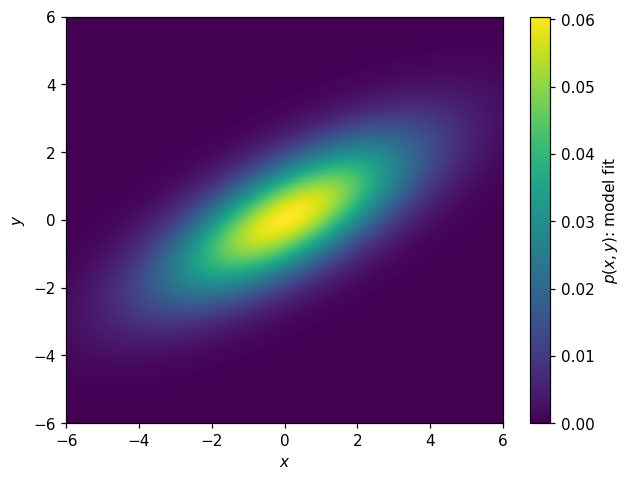

In [52]:
fig, ax = plt.subplots()
hl.plot2d(h_model_p2d, cbar=True, clabel='$p(x,y)$: model fit')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

We can use this to plot the "truth" as well:

In [53]:
h_truth_p2d = hl.hist_from_eval(
    (lambda x, y: model_p2d((x,y), 0, np.exp(1), 0, 1, np.radians(30))),
    vectorize=False, bins=k2d.bins)

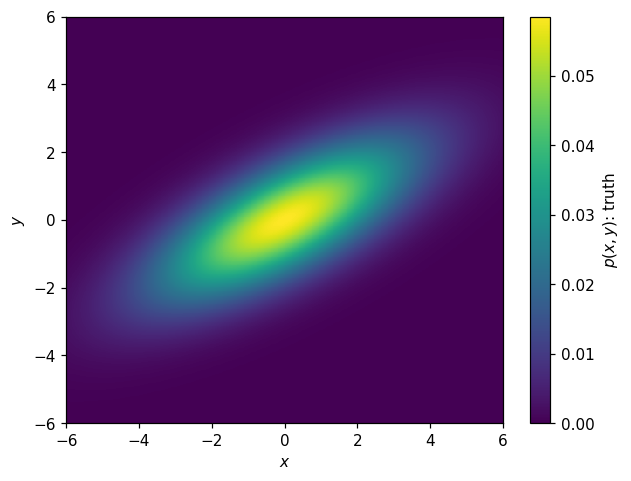

In [54]:
fig, ax = plt.subplots()
hl.plot2d(h_truth_p2d, cbar=True, clabel='$p(x,y)$: truth')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's sum this up by plotting the various parameterizations:

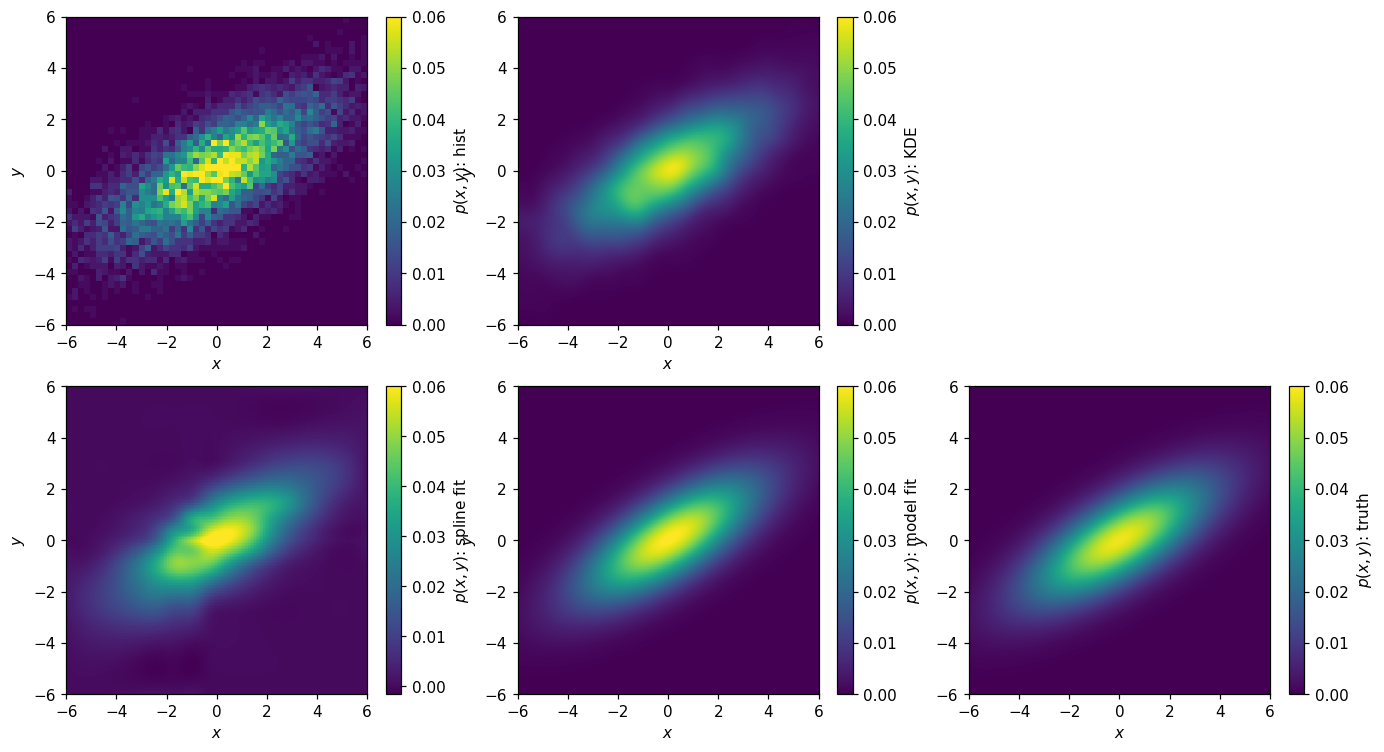

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = np.ravel(axs)
kw = dict(cbar=True, vmax=.06)
bins = p2d.bins
hl.plot2d(axs[0], p2d,
          clabel='$p(x,y)$: hist', **kw)
hl.plot2d(axs[1], k2d,
          clabel='$p(x,y)$: KDE', **kw)
hl.plot2d(axs[3], s2d.eval(bins=200),
          clabel='$p(x,y)$: spline fit', **kw)
hl.plot2d(axs[4], h_model_p2d,
          clabel='$p(x,y)$: model fit', **kw)
hl.plot2d(axs[5], h_truth_p2d,
          clabel='$p(x,y)$: truth', **kw)
for ax in axs:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
axs[2].set_visible(False)

and their ratios with respect to the truth:

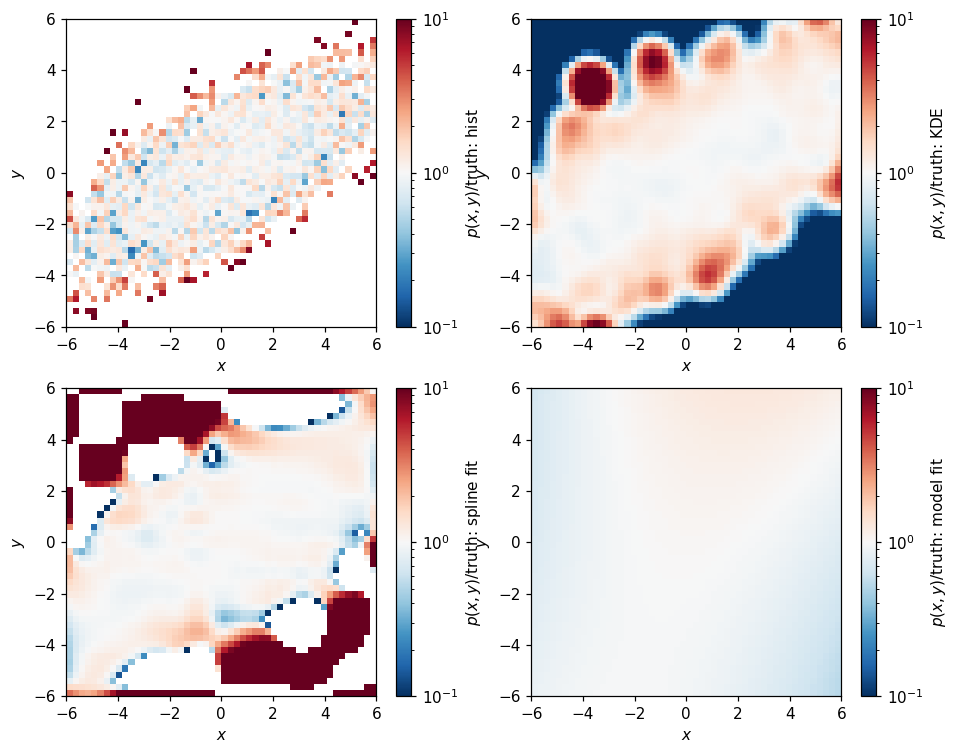

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = np.ravel(axs)
kw = dict(cbar=True, log=True, vmin=1e-1, vmax=1e1, cmap='RdBu_r')
bins = p2d.bins
hl.plot2d(axs[0], p2d.eval(bins=bins) / h_truth_p2d.eval(bins=bins),
          clabel='$p(x,y)/\mathsf{truth}$: hist', **kw)
hl.plot2d(axs[1], k2d.eval(bins=bins) / h_truth_p2d.eval(bins=bins),
          clabel='$p(x,y)/\mathsf{truth}$: KDE', **kw)
hl.plot2d(axs[2], s2d.eval(bins=bins) / h_truth_p2d.eval(bins=bins),
          clabel='$p(x,y)/\mathsf{truth}$: spline fit', **kw)
hl.plot2d(axs[3], h_model_p2d.eval(bins=bins) / h_truth_p2d.eval(bins=bins),
          clabel='$p(x,y)/\mathsf{truth}$: model fit', **kw)
for ax in axs:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

Whoa, the outliers here look pretty bad.  Comparing by difference is a little less pessimistic:

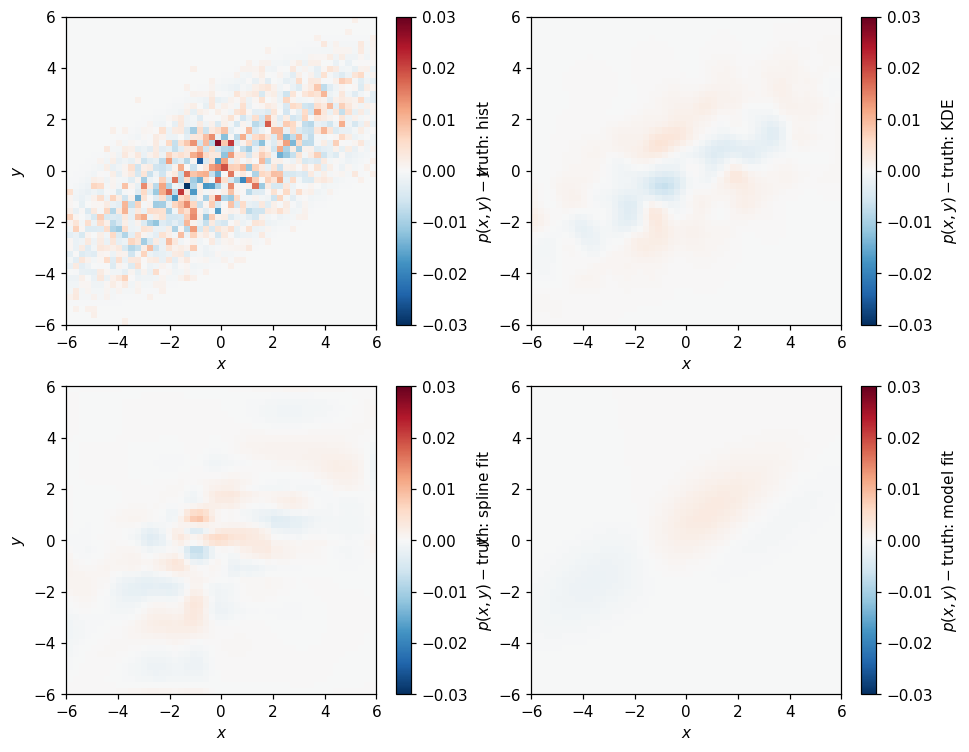

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = np.ravel(axs)
kw = dict(cbar=True, vmin=-.03, vmax=.03, cmap='RdBu_r')
bins = p2d.bins
ref = h_truth_p2d.eval(bins=bins)
hl.plot2d(axs[0], p2d.eval(bins=bins) - ref,
          clabel='$p(x,y)-\mathsf{truth}$: hist', **kw)
hl.plot2d(axs[1], k2d.eval(bins=bins) - ref,
          clabel='$p(x,y)-\mathsf{truth}$: KDE', **kw)
hl.plot2d(axs[2], s2d.eval(bins=bins) - ref,
          clabel='$p(x,y)-\mathsf{truth}$: spline fit', **kw)
hl.plot2d(axs[3], h_model_p2d.eval(bins=bins) - ref,
          clabel='$p(x,y)-\mathsf{truth}$: model fit', **kw)
for ax in axs:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

**Random Sampling**

Histlite allows random sampling in any number of dimensions.  As an example, consider:

In [58]:
N, seed = 5, 1
print(h2d.sample(N, seed=seed))
print(p2d.sample(N, seed=seed))
print(s2d.eval(bins=100).sample(N, seed=seed))

[array([-0.45783874,  1.24470245, -5.91706543, -1.34477581, -2.51068398]), array([-2.05939332,  1.60445268, -4.03093146,  2.37074818,  0.24657302])]
[array([-0.45783874,  1.24470245, -5.91706543, -1.34477581, -2.51068398]), array([-2.05939332,  1.60445268, -4.03093146,  2.37074818,  0.24657302])]
[array([-0.46891937,  1.34235123, -5.95853271, -1.1523879 , -2.45534199]), array([-2.94969666,  0.68222634, -3.69546573, -3.01462591, -0.59671349])]


Note, however, that with more dimensions, far increased statistics are required in the input data for the sampling to be stable with respect to modeling choices.

It is also possible to sample from a subset of dimensions, after specifying some of the parameters:

In [59]:
for x in [-3, 0, 3]:
    print(h2d.sample(N, x, seed=seed))

[array([-3.1813819 , -0.31052272,  0.22877188, -1.08092935, -2.56617245])]
[array([ 0.77583912, -0.31469618,  0.39610514, -0.561862  ,  1.43721256])]
[array([ 0.52094815, -0.71161515,  0.15890128,  1.33945822,  3.50148407])]


In [60]:
for y in [-3, 0, 3]:
    print(h2d.T.sample(N, y, seed=seed))

[array([ 0.75619039, -4.41946809, -3.59811482, -1.96971002, -4.14503631])]
[array([ 3.36920101, -1.70583997, -2.80190889,  1.60756293,  0.92207147])]
[array([3.46081916, 1.11091622, 5.1405659 , 3.59227166, 1.20438741])]


## Conclusions

One of the primary design goals of histlite is to serve as a convenient foundation for various higher-level analysis — especially maximum likelihood analysis.  It was originally written to support astrophysical neutrino sources in [IceCube](https://icecube.wisc.edu/).  Recently, histlite is also being investigated as a building block in neutrinoless double-beta(0νββ) decay searches by [nEXO](https://nexo.llnl.gov/).

Here we've surveyed features supporting 1D and 2D PDFs.  It's no problem to work with higher dimensional PDFs, with the exception that SciPy spline routines become extremely RAM-intensive as the dimensionality increases.

What's next?  Contact me if you have any requests — I think the next tutorial will cover slicing, projections, and more details on histogram arithmetic.